In [1]:
import os
import sys
import glob
import json
import shutil
import subprocess
import datetime as dt
from datetime import datetime
from functools import lru_cache
from typing import List, Union, Tuple
from contextlib import contextmanager

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import torch
from numba import jit

from osgeo import gdal
import osgeo_utils.gdal_merge
import rasterio
from rasterio.windows import Window
import geopandas as gpd
import rioxarray as rxr

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, recall_score, f1_score, precision_score, 
                             confusion_matrix, matthews_corrcoef, cohen_kappa_score, 
                             hamming_loss, classification_report)

import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap



@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloc
    
    o de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

#np.set_printoptions(threshold=sys.maxsize, edgeitems=sys.maxsize, linewidth=sys.maxsize, precision=sys.maxsize)

In [3]:
def listdir_fullpath(d: str) -> List[str]:
    
    """
    Retorna uma lista de caminhos completos para os arquivos em um diretório.
    """
    
    return [os.path.join(d, f) for f in sorted(os.listdir(d))]

class AmbienteIncorretoError(Exception):
    def __init__(self):
        self.message = "Necessário estar no ambiente 'km_predict' para rodar o modelo"
        super().__init__(self.message)


class Preprocessing:
    def __init__(self, caminho: str) -> None:
        self.caminho: str = caminho  # Pasta onde as imagens .SAFE estão
        self.abs_caminho: str = os.path.abspath(self.caminho)
        self.imgs_diretorio: List[str] = os.listdir(self.caminho)  # Nome de cada imagem .SAFE no diretório
        self.diretorios_tif: List[str] = sorted([diretorio.replace('.SAFE', '.TIF') for diretorio in self.imgs_diretorio if diretorio.endswith('.SAFE')])
        self.caminho_completo_lista: List[str] = [item for item in listdir_fullpath(self.caminho) if item.endswith('.SAFE')]

    def merge_tif_files(self, nome_TIF: str, output_name:str) -> None:
        """
        Mescla arquivos TIFF em um único arquivo usando gdal_merge.
        """
        with cwd(nome_TIF):
            if os.path.exists(output_name):
                os.remove(output_name)
            arquivos_tif: List[str] = glob.glob('*B*.tif')
            arquivos_tif: List[str] = self._sort_files(arquivos_tif,sufix='.tif')
            comando: List[str] = ['gdal_merge.py', '-o', output_name, '-of', 'Gtiff', '-separate', '-ot', 'FLOAT32', '-co', 'BIGTIFF=YES'] + arquivos_tif
            parameters = ['', '-o', output_name] + arquivos_tif + ['-separate', '-co', 'COMPRESS=LZW','-co','BIGTIFF=YES','-co', 'COMPRESS=LZW']
            osgeo_utils.gdal_merge.main(parameters)
            list(map(os.remove, arquivos_tif))

    def _create_tif_folder(self) -> None:
        """
        Cria pastas que serão utilizadas para o resultado dos modelos.
        """
        for tif_dir in self.diretorios_tif:
            if os.path.exists(tif_dir):
                shutil.rmtree(f'./{tif_dir}')
            os.makedirs(tif_dir)
        self._modify_img_diretorio()

    def _modify_img_diretorio(self) -> None:
        self.imgs_diretorio: List[str] = [diretorio for diretorio in self.imgs_diretorio if diretorio.endswith('.SAFE')]

    def jp2_to_tif(self, tif_dim: List[str] = ['10980','10980'], output_name: str = 'merge.tif', create_folder:bool = True) -> None:
        """
        Converte arquivos JP2 para TIFF usando gdal_translate.
        """
        with cwd(self.caminho):
            if create_folder:
                self._create_tif_folder()
            for diretorio in self.imgs_diretorio:
                files: List[str] = glob.glob(os.path.join(f'{diretorio}', 'GRANULE', '*', 'IMG_DATA', '*B*.jp2'))
                files: List[str] = self._sort_files(files,sufix='.jp2')
                nome_TIF: str = diretorio.replace('.SAFE', '.TIF')
                commands: List[List[str]] = []
                
                for f in files:
                    input_path: str = f
                    output_path: str = nome_TIF + '/' + os.path.splitext(os.path.basename(f))[0] + '.tif'
                    if os.path.exists(output_path):
                        os.remove(output_path)
                    cmd: List[str] = ['gdal_translate', input_path, '-ot', 'Float32', '-of', 'Gtiff', '-outsize', tif_dim[0], tif_dim[1], output_path, '-co', 'BIGTIFF=YES']
                    commands.append(cmd)
                    
                for cmd in commands:
                    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                    
                self.merge_tif_files(nome_TIF,output_name=output_name)
            
                    
                    
    def _sort_files(self, lista: list, sufix: str):
        lista = sorted(lista)

        b08_name: int = [item for item in lista if item.endswith(f"B08{sufix}")][0]
        b08_index: int = lista.index(b08_name)

        b8A_name: int = [item for item in lista if item.endswith(f"B8A{sufix}")][0]
        b8A_index: int = lista.index(b8A_name)

        lista.insert(b08_index + 1, lista.pop(b8A_index))
        
        return lista

    def _criar_symlinks_kappaMask(self, kappa_mask_folder: str) -> None:
        """
        Cria symlinks para pasta "data" do kappamask.
        """
        with cwd(kappa_mask_folder):
            if not os.path.exists('./data'):
                os.makedirs('data')
                
        pasta_origem: str = os.path.abspath(kappa_mask_folder)
        for diretorio in self.caminho_completo_lista:
            caminho_pasta: str = self.caminho + '/' + diretorio
            pasta_destino: str = os.path.abspath(caminho_pasta)
            symlink_path: str = os.path.join(pasta_origem, "data", os.path.basename(pasta_destino))
            try:
                os.symlink(pasta_destino, symlink_path)
                print(f"Symlink criado com sucesso: {symlink_path} -> {pasta_destino}")
            except FileExistsError:
                return
            except Exception as e:
                print(f"Erro ao criar symlink: {e}")

    def _config_json_kappa(self, kappa_mask_folder, product_name, architecture, json_config_name) -> None:
        diretorio_atual = self.abs_caminho
        print(diretorio_atual)
        json_config: dict = {
            "cm_vsm_executable": "cm_vsm",
            "folder_name": f"{diretorio_atual}",
            "product_name": f"{product_name.replace('.SAFE','')}",
            "level_product": "L1C",
            "overlapping": 0.0625,
            "tile_size": 512,
            "resampling_method": "sinc",
            "architecture": f"{architecture}",
            "batch_size": 1,
            "aoi_geometry": ""
        }
        caminho_json_config: str = f'./config/{json_config_name}'
        with cwd(kappa_mask_folder):
            with open(caminho_json_config, 'w') as arquivo:
                json.dump(json_config, arquivo, indent=2)

class Modelos(Preprocessing):
    def __init__(self, caminho: str) -> None:
        self.caminho = caminho
        super().__init__(caminho)

    def start(self,create_folder) -> None:
        """Começa a etapa de pré-processamento dos arquivos .jp2"""
        self.jp2_to_tif(create_folder=create_folder)
        df = Modelos.get_gt_predict(self.caminho.split('/')[-1].upper())
        with cwd(self.caminho):
            list(map(shutil.rmtree, self.diretorios_tif))
        return df
        
    @staticmethod
    def read_tif_values(tif_path, x, y):
        with rasterio.open(tif_path) as src:
            # Converte as coordenadas x, y em índices de linha e coluna no raster
            row, col = src.index(x, y)
            values = []
            for i in range(1, src.count + 1):  # Para cada banda
                window = Window(col, row, 1, 1)
                band_values = src.read(i, window=window)
                try: 
                    values.append(band_values[0][0])
                except:
                    continue
            return values

    @staticmethod
    def tifs(df_rotulos, index, name,regiao):
        ponto_de_montagem = f'/media/jean/90D8B801D8B7E41E/Ubuntu/{regiao.title()}'
        destino = os.path.abspath(ponto_de_montagem)
        with cwd(destino):
            with cwd(name):
                geotiff_path = 'merge.tif'
                # Lista para armazenar os valores das bandas
                band_values_list = []

                # Itera sobre cada linha do dataframe
                for _, row in df_rotulos.iterrows():
                    x, y = row['x'], row['y']
                    values = Modelos.read_tif_values(geotiff_path, x, y)
                    band_values_list.append(values)

                # Adiciona os valores das bandas ao dataframe original
                band_values_array = np.array(band_values_list)
                for i in range(band_values_array.shape[1]):
                    df_rotulos[f'band_{i + 1}'] = band_values_array[:, i]

                return df_rotulos
            
    @staticmethod
    def get_gt_predict(regiao):
        def get_value_from_data_df(row):
            return data_df[row['x']][float(row['y'])]
        resultado = {}
        with cwd('./Pontos_Validados/'):
            with cwd(f'./{regiao.upper()}'):
                dates = [x for x in os.listdir() if not x in (".ipynb_checkpoints")]
                i=0
                for data in dates:
                    date = f'{data}/'
                    with cwd(date):
                        models = [x for x in sorted(os.listdir()) if ( x != ".ipynb_checkpoints") and (not(x.endswith('.xml'))) and (not(x.endswith('.jp2')))]
                        for model in models:
                            with cwd(os.path.join(model)):
                                xml = [x for x in os.listdir(f'../') if x.endswith("xml")][0].split('_')[4:11]
                                name = '_'.join(xml).replace('.SAFE','.TIF')
                                files = sorted(os.listdir())  
                                shp = [shp for shp in files if shp.endswith('.shp')][0]
                                shapefile = gpd.read_file(shp)
                                if 'GrndTruth' not in shapefile.columns:
                                    shapefile = shapefile.rename(columns={shapefile.columns[0]:"GrndTruth"})
                                new_df = shapefile['geometry'].get_coordinates()
                                df = pd.concat([new_df,shapefile['GrndTruth']],axis=1)
                                display(df)
                                df['datetime'] = pd.to_datetime(data.replace('(1)','').replace('_','/'),dayfirst=True)
                                df['modelo'] = model
                                df = Modelos.tifs(df,i,name,regiao)
                                resultado[f'{regiao}_{model}_{data}'] = df
        return resultado
    
pasta_principal = '/media/jean/90D8B801D8B7E41E/Ubuntu/'
for i in os.listdir(pasta_principal):
    pasta_regiao = os.path.abspath(os.path.join(pasta_principal,i))
    obj: Modelos = Modelos(pasta_regiao)
    teste_df_regiao = obj.start(create_folder=True)  # Executar uma ÚNICA vez na pasta no qual as imagens estão.
    pd.concat(teste_df_regiao.values(),axis=0).to_csv(f'{i.title()}_pixels.csv')

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90

,x,y,GrndTruth
0,351210.0,9798970.0,4
1,352530.0,9792990.0,0
2,359970.0,9792190.0,1
3,360210.0,9781370.0,1
4,369650.0,9798890.0,0
...,...,...,...
247,394810.0,9693270.0,4
248,384330.0,9692930.0,0
249,389870.0,9691770.0,1
250,391510.0,9691050.0,0


,x,y,GrndTruth
0,350755.0,9794045.0,1
1,350905.0,9791265.0,4
2,360545.0,9800015.0,1
3,358365.0,9795385.0,1
4,354275.0,9793945.0,2
...,...,...,...
245,385395.0,9695185.0,1
246,383665.0,9691465.0,1
247,396515.0,9697455.0,4
248,401125.0,9693365.0,1


,x,y,GrndTruth
0,375750.0,9781410.0,8
1,375250.0,9781010.0,8
2,392730.0,9799750.0,4
3,399650.0,9795810.0,3
4,391250.0,9795390.0,4
...,...,...,...
239,399770.0,9695150.0,8
240,394630.0,9693530.0,8
241,382930.0,9693410.0,6
242,382090.0,9691590.0,4


,x,y,GrndTruth
0,316170.0,9880890.0,2
1,311390.0,9880330.0,2
2,316410.0,9879910.0,4
3,332690.0,9899010.0,0
4,330450.0,9896490.0,0
...,...,...,...
245,355130.0,9796330.0,4
246,344610.0,9793550.0,0
247,359350.0,9792590.0,4
248,367810.0,9796050.0,0


,x,y,GrndTruth
0,304355.0,9900005.0,1
1,300955.0,9894135.0,3
2,301325.0,9894005.0,1
3,301375.0,9890975.0,1
4,307025.0,9890615.0,4
...,...,...,...
245,334015.0,9790545.0,1
246,341305.0,9797605.0,1
247,341255.0,9792005.0,4
248,355805.0,9793585.0,1


,x,y,GrndTruth
0,359310.0,9896710.0,4
1,356090.0,9896110.0,8
2,346610.0,9895990.0,3
3,344910.0,9895470.0,3
4,351110.0,9893710.0,3
...,...,...,...
243,342370.0,9797050.0,9
244,358350.0,9795890.0,9
245,346770.0,9791090.0,8
246,362990.0,9797270.0,9


...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90

,x,y,GrndTruth
0,616890.0,8999950.0,0
1,617490.0,8997110.0,2
2,605050.0,8995410.0,4
3,603410.0,8994970.0,2
4,610390.0,8993730.0,0
...,...,...,...
248,674310.0,8893010.0,0
249,662270.0,8892330.0,4
250,691850.0,8894170.0,0
251,682750.0,8893090.0,4


,x,y,GrndTruth
0,605795.0,8999945.0,1
1,607555.0,8996235.0,2
2,604725.0,8995245.0,4
3,603915.0,8994275.0,3
4,608995.0,8993345.0,3
...,...,...,...
244,671545.0,8896475.0,2
245,676665.0,8894305.0,1
246,681435.0,8893655.0,3
247,682645.0,8894565.0,1


,x,y,GrndTruth
0,614190.0,8998810.0,4
1,610090.0,8996470.0,9
2,614470.0,8996170.0,4
3,612670.0,8993590.0,4
4,620370.0,8991450.0,5
...,...,...,...
243,663390.0,8896110.0,8
244,670150.0,8893850.0,5
245,680030.0,8891290.0,5
246,689050.0,8896070.0,5


,x,y,GrndTruth
0,602190.0,8999790.0,4
1,600690.0,8999530.0,4
2,602090.0,8999350.0,4
3,602270.0,8999250.0,4
4,600590.0,8998810.0,4
...,...,...,...
255,674890.0,8891730.0,0
256,695270.0,8895450.0,0
257,697090.0,8893990.0,0
258,696010.0,8891670.0,0


,x,y,GrndTruth
0,600505.0,8996825.0,4
1,601705.0,8996365.0,3
2,607295.0,8990835.0,1
3,611205.0,8995325.0,1
4,620385.0,8992275.0,1
...,...,...,...
248,675605.0,8893225.0,3
249,687595.0,8895615.0,3
250,681985.0,8891625.0,3
251,695265.0,8893945.0,3


,x,y,GrndTruth
0,601370.0,9000030.0,8
1,601470.0,8999050.0,9
2,601830.0,8999030.0,9
3,600590.0,8998970.0,9
4,601530.0,8998930.0,9
...,...,...,...
243,688050.0,8897450.0,4
244,698030.0,8894930.0,5
245,702210.0,8892230.0,5
246,689890.0,8891230.0,6


...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90

,x,y,GrndTruth
0,807790.0,9499930.0,4
1,816970.0,9497150.0,4
2,808210.0,9493350.0,4
3,819170.0,9491990.0,4
4,804250.0,9489130.0,4
...,...,...,...
250,874210.0,9392730.0,4
251,872590.0,9391050.0,4
252,888870.0,9395450.0,4
253,882210.0,9391650.0,4


,x,y,GrndTruth
0,800565.0,9499775.0,3
1,802765.0,9499355.0,1
2,801435.0,9493695.0,1
3,801425.0,9490935.0,3
4,818865.0,9499335.0,3
...,...,...,...
239,880875.0,9392885.0,4
240,890495.0,9396545.0,4
241,884095.0,9391855.0,4
242,900035.0,9396975.0,3


,x,y,GrndTruth
0,817490.0,9499830.0,4
1,804690.0,9497030.0,4
2,802510.0,9495730.0,4
3,802710.0,9493430.0,9
4,807230.0,9491210.0,4
...,...,...,...
238,869190.0,9392570.0,2
239,868310.0,9391530.0,2
240,865530.0,9391250.0,8
241,892530.0,9390850.0,9


,x,y,GrndTruth
0,204210.0,9499730.0,4
1,200270.0,9495010.0,4
2,217570.0,9490510.0,2
3,213370.0,9490050.0,0
4,203890.0,9489350.0,4
...,...,...,...
249,275290.0,9392790.0,0
250,298510.0,9395770.0,2
251,291210.0,9394870.0,4
252,282910.0,9390370.0,4


,x,y,GrndTruth
0,209415.0,9499845.0,4
1,209955.0,9499765.0,4
2,208035.0,9494995.0,4
3,210145.0,9490575.0,1
4,220025.0,9499905.0,4
...,...,...,...
245,271625.0,9391315.0,3
246,264455.0,9390455.0,1
247,275695.0,9393465.0,4
248,282855.0,9395785.0,1


,x,y,GrndTruth
0,208730.0,9499850.0,9
1,209210.0,9493530.0,9
2,212650.0,9488030.0,5
3,212830.0,9487430.0,10
4,211490.0,9482070.0,4
...,...,...,...
242,291930.0,9393470.0,3
243,284590.0,9391270.0,9
244,288690.0,9390610.0,3
245,288630.0,9390410.0,3


...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90

,x,y,GrndTruth
0,808030.0,8898890.0,0
1,803710.0,8898250.0,0
2,817070.0,8897790.0,0
3,815350.0,8897270.0,0
4,807410.0,8896310.0,0
...,...,...,...
247,807770.0,8791650.0,0
248,810490.0,8791550.0,4
249,806050.0,8791330.0,4
250,804710.0,8791070.0,0


,x,y,GrndTruth
0,800955.0,8899765.0,1
1,803965.0,8898245.0,4
2,801575.0,8897785.0,1
3,808545.0,8897305.0,1
4,802755.0,8896375.0,3
...,...,...,...
253,802765.0,8794615.0,3
254,806395.0,8793125.0,1
255,808605.0,8792465.0,1
256,803145.0,8791275.0,3


,x,y,GrndTruth
0,2.138120e+06,8.776228e+06,9
1,2.131313e+06,8.826475e+06,8
2,2.143947e+06,8.819574e+06,9
3,2.132209e+06,8.816486e+06,9
4,2.150154e+06,8.801875e+06,2
...,...,...,...
231,2.129640e+06,8.760993e+06,8
232,2.142471e+06,8.767444e+06,9
233,2.146564e+06,8.846127e+06,5
234,2.156396e+06,8.820295e+06,9


,x,y,GrndTruth
0,769420.348485,8.719681e+06,0
1,772461.302884,8.728563e+06,0
2,798167.087960,8.767490e+06,0
3,772701.098821,8.740500e+06,0
4,808747.513464,8.799856e+06,0
...,...,...,...
244,794294.166865,8.741824e+06,4
245,801596.545433,8.740738e+06,4
246,789315.549770,8.796055e+06,0
247,795415.946176,8.732094e+06,0


,x,y,GrndTruth
0,791065.0,8799985.0,1
1,786405.0,8798225.0,1
2,786555.0,8797065.0,1
3,783635.0,8791065.0,1
4,788295.0,8790875.0,1
...,...,...,...
250,800595.0,8694185.0,1
251,799855.0,8691755.0,1
252,809635.0,8696955.0,1
253,808985.0,8695145.0,1


,x,y,GrndTruth
0,797770.0,8798250.0,5
1,795430.0,8798150.0,4
2,798470.0,8796930.0,4
3,794110.0,8795450.0,4
4,796950.0,8794690.0,4
...,...,...,...
242,793670.0,8691230.0,4
243,799890.0,8690710.0,4
244,806250.0,8695370.0,4
245,808610.0,8693690.0,4


...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90.

,x,y,GrndTruth
0,900570.0,9697310.0,4
1,892490.0,9695550.0,4
2,897290.0,9694810.0,4
3,890890.0,9694790.0,4
4,894450.0,9693710.0,4
...,...,...,...
249,905790.0,9597270.0,0
250,906850.0,9595530.0,0
251,905170.0,9593430.0,4
252,903390.0,9592430.0,4


,x,y,GrndTruth
0,890275.0,9696245.0,4
1,888775.0,9694015.0,4
2,888695.0,9690765.0,3
3,891885.0,9690505.0,4
4,895545.0,9698645.0,4
...,...,...,...
244,894315.0,9592935.0,1
245,893655.0,9591745.0,1
246,903555.0,9597155.0,1
247,904005.0,9596345.0,1


,x,y,GrndTruth
0,890728.147283,9.682585e+06,5
1,898176.156911,9.695372e+06,9
2,891109.658166,9.629913e+06,5
3,889207.177215,9.670445e+06,5
4,891073.249511,9.593057e+06,9
...,...,...,...
238,882369.049497,9.622849e+06,10
239,898021.525607,9.672415e+06,4
240,904550.475153,9.604962e+06,4
241,872828.999376,9.619550e+06,8


,x,y,GrndTruth
0,219890.0,9689650.0,0
1,240890.0,9697750.0,4
2,222730.0,9693930.0,1
3,237990.0,9693290.0,4
4,221530.0,9692570.0,0
...,...,...,...
250,261810.0,9590730.0,4
251,297690.0,9594190.0,2
252,293170.0,9593670.0,4
253,295750.0,9591490.0,4


,x,y,GrndTruth
0,225185.0,9699655.0,1
1,228005.0,9698645.0,2
2,226415.0,9696375.0,4
3,233955.0,9698935.0,4
4,234135.0,9695825.0,1
...,...,...,...
256,281335.0,9591405.0,4
257,286595.0,9594655.0,4
258,285005.0,9590295.0,4
259,296045.0,9593145.0,4


,x,y,GrndTruth
0,306394.572084,9.669326e+06,9
1,293168.025352,9.619472e+06,9
2,306596.169966,9.678191e+06,2
3,265371.701847,9.655513e+06,9
4,299490.853305,9.683812e+06,9
...,...,...,...
242,228275.667520,9.608362e+06,9
243,298340.001730,9.637789e+06,9
244,288809.607386,9.603151e+06,9
245,243532.040025,9.638397e+06,9


In [16]:
pixels = pd.concat([pd.read_csv(x) for x in os.listdir() if x.endswith('.csv')]).drop([f'band_{i}' for i in range(14,17)],axis=1).drop(['Unnamed: 0','x','y','datetime'],axis=1)

In [33]:
def fmask_replace(pixels):
    chave = {0: 0, 1: 1, 2: 2, 4: 3}
    fmask = pixels[pixels['modelo'] == 'Fmask']['GrndTruth'].replace(chave)
    return fmask

def kappa_replace(pixels):
    chave = {1: 0, 2: 2, 3: 4, 4: 3}
    kappa = pixels[pixels['modelo'].isin(['Kappamask','KappaMask'])]['GrndTruth'].replace(chave)
    return kappa

def sen2cor_replace(pixels):
    chave = {2: 2, 3: 2, 4: 0, 5: 0, 6: 1, 8: 3, 9: 3, 10: 4}
    kappa = pixels[pixels['modelo'].isin(['Sen2Core','Sen2Cor'])]['GrndTruth'].replace(chave)
    return kappa

fmask_rotulos = fmask_replace(pixels)
kappa_rotulos = kappa_replace(pixels)
sen2cor_rotulos = sen2cor_replace(pixels)

In [38]:
pixels['GrndTruth'] = pd.concat([fmask_rotulos,kappa_rotulos,sen2cor_rotulos]).values

In [100]:
pixels = pixels.reset_index().drop('index',axis=1)

In [323]:
pixels.drop('modelo',axis=1).to_csv('pixels_nuvem.csv',index=None)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold


def custom_metric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')  # Precisão micro-average para dados multiclasse
    recall = recall_score(y_true, y_pred, average='macro')  # Recall micro-average para dados multiclasse
    f1 = f1_score(y_true, y_pred, average='macro')  # F1 micro-average para dados multiclasse
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }


# Lista de classificadores
classifiers = [
    LGBMClassifier(),
    ExtraTreesClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(),
    XGBClassifier(random_state=42),
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    DummyClassifier(strategy="most_frequent")  # Adicionando o Dummy Classifier
]

X = pixels.drop(['GrndTruth', 'modelo'], axis=1).dropna()

# Ajustar a variável alvo 'y' para corresponder aos índices de 'X' após a remoção de valores ausentes
y = pixels.loc[X.index, 'GrndTruth']

# Dividir os dados em conjuntos de treino e teste, estratificando pela variável alvo 'y'
#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

# Ajustar o LabelBinarizer para a variável alvo 'y'
label_binarizer = LabelBinarizer()
y_encoded = label_binarizer.fit_transform(y)

# Iterar sobre cada classificador
for clf in classifiers:
    clf_results = []  # Lista para armazenar os resultados de cada fold para este classificador
    for train_idx, test_idx in stratified_kfold.split(X, y):
        # Separar os dados em conjuntos de treino e teste
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        # Criar um pipeline para o classificador
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Normalização dos dados
            ('pca', PCA(n_components=11)),   # Redução de dimensionalidade com PCA
            ('classifier', MultiOutputClassifier(clf))  # Classificador
        ])

        # Treinar o pipeline
        pipeline.fit(X_train, y_train)

        # Fazer previsões no conjunto de teste
        y_pred = pipeline.predict(X_test)

        # Calcular métricas
        metrics = custom_metric(y_test, y_pred)

        # Armazenar os resultados deste fold para este classificador
        clf_results.append(metrics)

    # Calcular a média dos resultados de todos os folds para este classificador
    avg_metrics = {metric: np.mean([result[metric] for result in clf_results]) for metric in clf_results[0].keys()}

    # Armazenar os resultados médios para este classificador
    results.append((clf.__class__.__name__, avg_metrics))

# Criar DataFrame com os resultados médios para todos os classificadores
df_results = pd.DataFrame({clf_name: metrics for clf_name, metrics in results}).T

# Exibir o DataFrame
display(df_results)

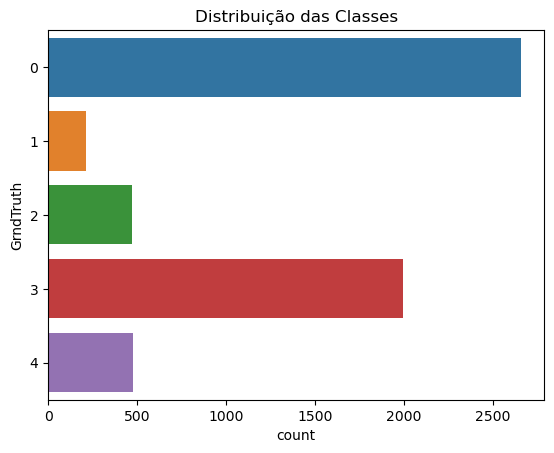

In [239]:
sns.countplot(y=y_train)
plt.title('Distribuição das Classes')
plt.show()

In [238]:
metricas['Time Taken'] = models['Time Taken']
metricas.sort_values(by='F1 Score',ascending=False)

,Accuracy,Precision,Recall,F1 Score,Cohen's Kappa,Time Taken
LGBMClassifier,0.49,0.43,0.49,0.44,0.14,0.43
ExtraTreesClassifier,0.49,0.43,0.49,0.44,0.13,0.70
RandomForestClassifier,0.49,0.44,0.49,0.44,0.13,2.30
XGBClassifier,0.46,0.41,0.46,0.42,0.11,0.43
KNeighborsClassifier,0.45,0.40,0.45,0.41,0.08,0.14
SVC,0.49,0.40,0.49,0.41,0.10,2.60
BaggingClassifier,0.44,0.39,0.44,0.40,0.07,0.67
GaussianNB,0.43,0.37,0.43,0.40,0.07,0.01
LabelSpreading,0.39,0.38,0.39,0.39,0.07,1.10
QuadraticDiscriminantAnalysis,0.41,0.39,0.41,0.39,0.08,0.01
